In [386]:
import copy
from collections import defaultdict
from dataclasses import dataclass, field
from enum import IntEnum
from typing import TypeVar, Sequence, Optional, List, Iterator, Union

import clingo
import clingox.program
from clingraph import Factbase, compute_graphs


In [387]:
ForwardSymbol = TypeVar('ForwardSymbol', bound='Symbol')


class Symbol:
    def is_function(self) -> bool:
        return isinstance(self, Function)

    def is_unary_operation(self) -> bool:
        return isinstance(self, UnaryOperation)

    def is_variable(self) -> bool:
        return isinstance(self, Variable)

    def is_term(self) -> bool:
        return isinstance(self, Term)

    @classmethod
    def from_clingo_symbol(cls, symbol: clingo.Symbol) -> ForwardSymbol:
        if symbol.type is clingo.SymbolType.Function:
            name: str = symbol.name
            arguments = tuple(SubSymbol.from_clingo_symbol(argument) for argument in symbol.arguments)
            return Function(name, arguments)
        else:
            assert False, "Unknown clingo.SymbolType {}.".format(symbol.type)


class SubSymbol(Symbol):

    @classmethod
    def from_clingo_symbol(cls, symbol: clingo.Symbol) -> ForwardSymbol:
        if symbol.type is clingo.SymbolType.Number:
            return Term(IntegerConstant(symbol.number))
        elif symbol.type is clingo.SymbolType.String:
            return Term(StringConstant(symbol.string))
        elif symbol.type is clingo.SymbolType.Function:
            return Symbol.from_clingo_symbol(symbol)
        else:
            assert False, "Unknown clingo.SymbolType {}.".format(symbol.type)


In [388]:
@dataclass(frozen=True, order=True)
class Variable(SubSymbol):
    name: str

    def __str__(self):
        return self.name

@dataclass(frozen=True, order=True)
class StringConstant:
    string: str = ""

    def __str__(self):
        return '"{}"'.format(self.string)

@dataclass(frozen=True, order=True)
class IntegerConstant:
    number: int = 0

    def __str__(self):
        return str(self.number)


@dataclass(frozen=True, order=True)
class Term(SubSymbol):
    constant: Union[IntegerConstant, StringConstant] = field(default=IntegerConstant())

    def __str__(self):
        return str(self.constant)

In [389]:
ForwardAtom = TypeVar('ForwardAtom', bound='Atom')
ForwardFunction = TypeVar('ForwardFunction', bound='Function')
ForwardUnaryOperator = TypeVar('ForwardUnaryOperator', bound='UnaryOperator')


@dataclass(frozen=True, order=True)
class Function(Symbol):
    name: Optional[str] = None
    arguments: Sequence[SubSymbol] = ()

    @property
    def arity(self):
        return len(self.arguments)

    def __str__(self):
        if self.name is None and not self.arguments:
            return "()"
        elif self.name is not None and not self.arguments:
            return self.name
        elif self.name is None and self.arguments:
            return "({})".format(','.join(map(str, self.arguments)))
        else:
            return "{}({})".format(self.name, ','.join(map(str, self.arguments)))

    def match(self, name: Optional[str], arity: int = 0) -> bool:
        return name == self.name and arity == len(self.arguments)

    def match_signature(self, other: ForwardFunction) -> bool:
        return self.match(other.name, other.arity)


class UnaryOperatorType(IntEnum):
    Minus = 1


@dataclass(frozen=True, order=True)
class UnaryOperation:
    operator: UnaryOperatorType
    argument: SubSymbol

    def __str__(self) -> str:
        if self.operator is UnaryOperatorType.Minus:
            return "(-{})".format(self.argument)
        else:
            assert False, "Unknown UnaryOperatorType {}.".format(self.operator)


class BinaryOperatorType(IntEnum):
    Plus = 2


@dataclass(frozen=True, order=True)
class BinaryOperation:
    left: SubSymbol
    operator: BinaryOperatorType
    right: SubSymbol

    def __str__(self) -> str:
        if self.operator is BinaryOperatorType.Plus:
            return "({}+{})".format(self.left, self.right)


In [390]:
@dataclass(frozen=True, order=True)
class Atom:
    symbol: Symbol = field(default_factory=Function)

    def __str__(self) -> str:
        return str(self.symbol)

    def is_function(self) -> bool:
        return isinstance(self.symbol, Function)

    def is_unary_operation(self) -> bool:
        return isinstance(self.symbol, UnaryOperation)

    def get_top_function(self) -> Function:
        current = self.symbol
        while not isinstance(current, Function):
            if isinstance(current, UnaryOperation):
                current = current.argument
            else:
                assert False, "Unknown Type {} for Symbol {}.".format(type(current).__name__, current)
        return current

    def is_isomorph_to(self, other: ForwardAtom) -> bool:
        assert isinstance(other, Atom), "Atom {} should have type {}, but has type {}.".format(other, Atom.__name__,
                                                                                               type(other).__name__)
        stack_self: List[SubSymbol] = [self.symbol]
        stack_other: List[SubSymbol] = [other.symbol]
        while stack_self:
            if len(stack_self) != len(stack_other):
                return False
            current_self = stack_self.pop()
            current_other = stack_other.pop()
            if current_self.is_variable() and current_other.is_variable():
                if current_self.name != current_other.name:
                    return False
            elif not current_self.is_variable() and not current_other.is_variable():
                if type(current_self) != type(current_other):
                    return False
                if current_self.is_unary_operation() and current_other.is_unary_operation():
                    if current_self.operator != current_other.operator:
                        return False
                    stack_self.append(current_self.argument)
                    stack_other.append(current_other.argument)
                elif current_self.is_term() and current_other.is_term():
                    if current_self != current_other:
                        return False
                elif current_self.is_function() and current_other.is_function():
                    if not current_self.match_signature(current_other):
                        return False
                    stack_self.extend(current_self.arguments)
                    stack_other.extend(current_other.arguments)

        return True

    @staticmethod
    def from_clingo_symbol(symbol: clingo.Symbol) -> ForwardAtom:
        assert symbol.type is clingo.SymbolType.Function, "clingo.Symbol {} should have type {}, but has type {}.".format(
            symbol, clingo.SymbolType.Function, symbol.type)
        return Atom(Symbol.from_clingo_symbol(symbol))




In [391]:
class Sign(IntEnum):
    NoSign = 0
    DefaultNeg = 1

In [392]:
@dataclass(frozen=True, order=True)
class Literal:
    atom: Atom = field(default_factory=Atom)
    sign: Sign = Sign.NoSign

    def is_neg(self):
        return self.sign is Sign.DefaultNeg

    def is_pos(self):
        return self.sign is Sign.NoSign

    def __str__(self):
        if self.sign is Sign.DefaultNeg:
            return "not {}".format(self.atom)
        return str(self.atom)

    def __abs__(self):
        return Literal(sign=Sign.NoSign, atom=copy.deepcopy(self.atom))

    def __neg__(self):
        return Literal(sign=Sign(self.sign ^ 1), atom=self.atom)

    def __invert__(self):
        return Literal(sign=Sign(self.sign ^ 1), atom=self.atom)

In [393]:
class RuleLike:
    def is_rule(self) -> bool:
        return isinstance(self, Rule)

    def is_external(self) -> bool:
        return isinstance(self, External)

In [394]:

ForwardRule = TypeVar('ForwardRule', bound='Rule')
ForwardExternal = TypeVar('ForwardExternal', bound='External')


@dataclass(frozen=True, order=True)
class Rule(RuleLike):
    head: Optional[Literal] = None
    body: Sequence[Literal] = ()

    def __str__(self) -> str:
        if self.head is None and not self.body:
            return ":-."
        elif self.head is None:
            return ":- {}.".format(', '.join(map(str, self.body)))
        elif not self.body:
            return "{}.".format(self.head)
        else:
            return "{} :- {}.".format(self.head, ', '.join(map(str, self.body)))

    def is_ground(self) -> bool:
        pass

    def is_fact(self) -> bool:
        return self.head is not None and not self.body

    def as_external(self) -> ForwardExternal:
        return External(self.head.atom, self.body, ExternalType.false)

    def is_constraint(self) -> bool:
        return self.head is None

    def is_normal_rule(self) -> bool:
        return self.head is not None and self.body

    def is_head_relevant(self, atom: Atom) -> bool:
        if self.head is None:
            return False
        #if self.head.atom == atom:
        #    return True
        return self.head.atom.is_isomorph_to(atom)


In [395]:
ForwardExternalType = TypeVar('ForwardExternalType', bound='ExternalType')


class ExternalType(IntEnum):
    false = 0
    true = 1
    free = 2

    @staticmethod
    def from_truth_value(tv: clingo.TruthValue) -> ForwardExternalType:
        if tv is clingo.TruthValue.False_:
            return ExternalType.false
        elif tv is clingo.TruthValue.True_:
            return ExternalType.true
        else:
            assert tv is clingo.TruthValue.Free
            return ExternalType.free


@dataclass(frozen=True, order=True)
class External(RuleLike):
    atom: Atom = field(default_factory=Atom)
    body: Sequence[Literal] = ()
    external_type: ExternalType = ExternalType.false

    def __str__(self):
        if not self.body:
            return "#external {}. [{}]".format(self.atom, self.external_type.name)
        return "#external {} : {}. [{}]".format(self.atom, ', '.join(map(str, self.body)), self.external_type.name)


In [396]:
ForwardProgram = TypeVar('ForwardProgram', bound='Program')


@dataclass(frozen=True, order=True)
class Program:
    rules: Sequence[RuleLike] = field(default_factory=list)

    def __str__(self):
        return ' '.join(map(str, self.rules))

    def facts(self) -> Iterator[Atom]:
        for rule in self.rules:
            if rule.is_rule():
                assert isinstance(rule, Rule)
                if rule.is_fact():
                    yield rule
            if rule.is_external():
                assert isinstance(rule, External)
                if not rule.body:
                    yield rule

    def facts_as_external(self) -> ForwardProgram:
        new_rules = []
        for rule in self.rules:
            if rule.is_fact():
                new_rules.append(rule.as_external())
            else:
                new_rules.append(rule)
        return Program(new_rules)

    def support_rules(self, atom: Atom) -> Iterator[RuleLike]:
        for rule in self.rules:
            if rule.is_rule():
                assert isinstance(rule, Rule)
                if rule.is_head_relevant(atom):
                    yield rule
            elif rule.is_external():
                assert isinstance(rule, External)
                if rule.atom.is_isomorph_to(atom):
                    yield rule

    def ground(self) -> ForwardProgram:
        ctl = clingo.Control()
        prg = clingox.program.Program()
        obs = clingox.program.ProgramObserver(prg)
        ctl.register_observer(obs)
        ctl.add('base', [], str(self))
        ctl.ground([('base', [])])
        new_rules = []
        for fact in prg.facts:
            new_rules.append(Rule(Literal(Atom.from_clingo_symbol(fact.symbol))))
        for rule in prg.rules:
            if len(rule.head) == 0:
                head = None
            elif len(rule.head) == 1:
                if rule.head[0] not in prg.output_atoms:
                    continue
                head = Literal(Atom.from_clingo_symbol(prg.output_atoms[rule.head[0]]))
            else:
                assert False, "Unexpected length of rule head"
            body = [
                Literal(sign=Sign(body_literal < 0), atom=Atom.from_clingo_symbol(prg.output_atoms[abs(body_literal)]))
                for body_literal in rule.body]
            new_rules.append(Rule(head, body))
        for external in prg.externals:
            new_rules.append(External(Atom.from_clingo_symbol(prg.output_atoms[external.atom]), (),
                                      ExternalType.from_truth_value(external.value)))
        return Program(new_rules)

    def evaluate_forwards(self) -> Iterator[Sequence[Atom]]:
        ctl = clingo.Control()
        ctl.configuration.solve.models = 0
        ctl.add('base', [], str(self))
        ctl.ground([('base', [])])
        with ctl.solve(yield_=True) as solve_handle:
            for model in solve_handle:
                symbols = sorted(model.symbols(shown=True))
                atoms = tuple(Atom.from_clingo_symbol(symbol) for symbol in symbols)
                yield atoms

    def cautious_consequences(self) -> Sequence[Atom]:
        ctl = clingo.Control()
        ctl.configuration.solve.models = 0
        ctl.configuration.solve.enum_mode = 'cautious'
        ctl.add('base', [], str(self))
        ctl.ground([('base', [])])
        with ctl.solve(yield_=True) as solve_handle:
            model = None
            for m in solve_handle:
                model = m
            symbols = sorted(model.symbols(shown=True))
            atoms = tuple(Atom.from_clingo_symbol(symbol) for symbol in symbols)
            return atoms



In [397]:
a = Literal(Atom(Function('a')))
b = Literal(Atom(Function('b')))
c = Literal(Atom(Function('c')))
e = Literal(Atom(Function('e')))
f = Literal(Atom(Function('f')))
k = Literal(Atom(Function('k')))

r1 = Rule(a, [k, -b])
r2 = Rule(k, [e, -b])
r3 = Rule(c, [a, b])
r4 = Rule(b, [-a])
r5 = Rule(c, [k])
r6 = Rule(f, [e, -k, -c])
r7 = Rule(e)

p1 = Program([r1, r2, r3, r4, r5, r6, r7])
print(p1)

a :- k, not b. k :- e, not b. c :- a, b. b :- not a. c :- k. f :- e, not k, not c. e.


In [398]:
p1_t = p1.facts_as_external()
print(p1_t)

a :- k, not b. k :- e, not b. c :- a, b. b :- not a. c :- k. f :- e, not k, not c. #external e. [false]


In [399]:
p1_tg = p1_t.ground()
print('\n'.join(map(str, p1_tg.rules)))

b :- not a.
k :- not b, e.
a :- not b, k.
c :- b, a.
c :- k.
f :- not c, not k, e.
#external e. [false]


In [400]:
models = list(p1.evaluate_forwards())
print("Answer Sets:")
print('{', ' } { '.join(' '.join(map(str, model)) for model in models), '}')
model = models[0]

Answer Sets:
{ b e f } { a c e k }


In [401]:
cautious_consequences = p1.cautious_consequences()
print("Cautious Consequences:")
print('{', ' '.join(map(str, cautious_consequences)), '}')

Cautious Consequences:
{ e }


In [402]:
def preprocess_true_atoms(atom: Atom, body: Sequence[Literal], e, model, facts):
    a = Literal(atom)
    positive = set(literal for literal in body if literal.is_pos())
    pos = positive
    negative = set(literal for literal in body if literal.is_neg())
    neg = set(abs(literal) for literal in body if literal.is_neg())
    if pos <= model and neg.isdisjoint(model):
        s = frozenset(positive | negative)
        if a in model and not positive and not negative:
            s = frozenset("T")
        e[a].append(s)


def preprocess_false_atoms(atom: Atom, body: Sequence[Literal], e, model):
    a = Literal(atom)
    positive = set(literal for literal in body if literal.is_pos())
    negative = set(literal for literal in body if literal.is_neg())
    l = list(set(frozenset({-p}) for p in positive if p not in model) | set(
        frozenset({abs(n)}) for n in negative if abs(n) in model))
    if -a not in e:
        e[-a] = l
    else:
        t = []
        for s in l:
            for e_ in e[-a]:
                t.append(s | e_)
        e[-a] = t


def preprocess(program: Program, model: Sequence[Atom]) -> dict:
    e = defaultdict(list)
    facts = tuple(program.facts())
    model = set(Literal(atom) for atom in model)
    for rule in program.rules:
        if rule.is_external():
            atom: Atom = rule.atom
        elif rule.is_rule():
            atom: Atom = rule.head.atom
        else:
            assert False, "Unexpected RuleLike {} with type {}.".format(rule, type(rule).__name__)
        assert isinstance(atom, Atom), "Atom {} should have type {} but has type {}.".format(atom, Atom.__name__,
                                                                                             type(atom).__name__)
        bodies = (support_rule.body for support_rule in program.support_rules(atom))
        if Literal(atom) in model:
            for body in bodies:
                preprocess_true_atoms(atom, body, e, model, facts)
        else:
            for body in bodies:
                preprocess_false_atoms(atom, body, e, model)
    return e


In [403]:
dependency_dict = preprocess(p1_tg, model)
for sym, dep in dependency_dict.items():
    print(sym, " : [", sep='', end='')
    for d in dep:
        print("{", ', '.join(map(str, d)), "}", end='')
    print("]")

b : [{ not a }]
not k : [{ b }]
not a : [{ not k }{ b }]
not c : [{ not k, not a }]
f : [{ not c, e, not k }]
e : [{ T }]


In [404]:
body_dict = {}
index = 0
graph_rules = []
symbols = {}
for literal,bodies in dependency_dict.items():
    if literal not in symbols:
        symbol = literal.atom
        if literal.is_neg():
            symbol = UnaryOperation(UnaryOperatorType.Minus, symbol)
            label = Rule(Literal(Atom(Function('attr', (Function('node'), symbol, Function('label'), Term(StringConstant('¬' + str(literal.atom))))))))
            graph_rules.append(label)
        symbols[literal] = symbol
        node = Rule(Literal(Atom(Function('node', (symbol,)))))
        graph_rules.append(node)
    for body in bodies:
        if body not in body_dict:
            body_dict[body] = index
            node = Rule(Literal(Atom(Function('node', (Term(IntegerConstant(index)),)))))
            conjunction = Rule(Literal(Atom(Function('conjunction', (Term(IntegerConstant(index)),)))))
            graph_rules.append(node)
            graph_rules.append(conjunction)
            index += 1
        i = body_dict[body]
        symbol = symbols[literal]
        edge = Rule(Literal(Atom(Function('edge', [Function(arguments=(symbol, Term(IntegerConstant(i))))]))))
        graph_rules.append(edge)
        for lit in body:
            if lit not in symbols:
                if lit == 'T':
                    symbol = Term(StringConstant("T"))
                    symbols[lit] = symbol
                else:
                    symbol = lit.atom
                    if lit.is_neg():
                        symbol = UnaryOperation(UnaryOperatorType.Minus, symbol)
                        label = Rule(Literal(Atom(Function('attr', (Function('node'), symbol, Function('label'), Term(StringConstant('¬' + str(lit.atom))))))))
                        graph_rules.append(label)
                node = Rule(Literal(Atom(Function('node', (symbol,)))))
                graph_rules.append(node)
            else:
                symbol = symbols[lit]
            edge = Rule(Literal(Atom(Function('edge', [Function(arguments=(Term(IntegerConstant(i)), symbol))]))))
            graph_rules.append(edge)

graph_rules.append(Rule(Literal(Atom(Function('attr', (Function('edge'), Variable('E'), Function('dir'), Function('forward'))))), (Literal(Atom(Function('edge', (Variable('E'), )))),))) #attr(edge, E, dir, forward) :- edge(E,_G).

graph = Program(graph_rules)
print('\n'.join(map(str,graph_rules)))

node(b).
node(0).
conjunction(0).
edge((b,0)).
attr(node,(-a),label,"¬a").
node((-a)).
edge((0,(-a))).
attr(node,(-k),label,"¬k").
node((-k)).
node(1).
conjunction(1).
edge(((-k),1)).
edge((1,b)).
attr(node,(-a),label,"¬a").
node((-a)).
node(2).
conjunction(2).
edge(((-a),2)).
edge((2,(-k))).
edge(((-a),1)).
edge((1,b)).
attr(node,(-c),label,"¬c").
node((-c)).
node(3).
conjunction(3).
edge(((-c),3)).
edge((3,(-k))).
edge((3,(-a))).
node(f).
node(4).
conjunction(4).
edge((f,4)).
edge((4,(-c))).
node(e).
edge((4,e)).
edge((4,(-k))).
node(e).
node(5).
conjunction(5).
edge((e,5)).
node("T").
edge((5,"T")).
attr(edge,E,dir,forward) :- edge(E).


In [405]:
print_graph = copy.deepcopy(graph).ground()
print(print_graph)

edge((b,0)). edge((0,a)). edge((k,1)). edge((1,b)). edge((a,2)). edge((2,k)). edge((a,1)). edge((c,3)). edge((3,k)). edge((3,a)). edge((f,4)). edge((4,c)). edge((4,e)). edge((4,k)). edge((e,5)). edge((5,"T")). attr(node,a,label,"¬a"). attr(node,k,label,"¬k"). attr(node,c,label,"¬c"). attr(edge,(b,0),dir,forward). attr(edge,(0,a),dir,forward). attr(edge,(k,1),dir,forward). attr(edge,(1,b),dir,forward). attr(edge,(a,2),dir,forward). attr(edge,(2,k),dir,forward). attr(edge,(a,1),dir,forward). attr(edge,(c,3),dir,forward). attr(edge,(3,k),dir,forward). attr(edge,(3,a),dir,forward). attr(edge,(f,4),dir,forward). attr(edge,(4,c),dir,forward). attr(edge,(4,e),dir,forward). attr(edge,(4,k),dir,forward). attr(edge,(e,5),dir,forward). attr(edge,(5,"T"),dir,forward). node(b). node(0). node(1). node(2). node(3). node(f). node(4). node(e). node(5). node("T"). node(a). node(k). node(c). conjunction(0). conjunction(1). conjunction(2). conjunction(3). conjunction(4). conjunction(5).


In [406]:
fb = Factbase()
fb.add_fact_string(str(print_graph))

In [407]:
graphs = compute_graphs(fb)
graphs

{'default': <graphviz.graphs.Graph at 0x7fbf1d76b010>}

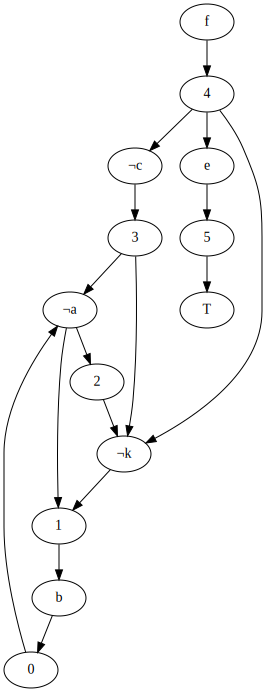

In [408]:
graphs['default']

In [ ]:
neg_cycle = """

negcycle((-U,V)) :- node(-U), negcycle((V,_)), negcycle((_, -U)).

"""